In [1]:
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.features import compute_aggregate_features

from market_impact.util.utils import normalize_imbalances

from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 100000

# Lag/window size for Hurst and the ACF
LAG = 100

## Load market orders raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'limit_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'long_memory')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['AAPL']

In [5]:
display(tsla_raw_df)

,Unnamed: 0,event_timestamp,side,lob_action,order_executed,execution_price,execution_size,ask,ask_volume,bid,...,sign,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,184298,2017-01-03 10:30:06.086276667,ASK,INSERT,False,NaN,0,219.39,600.0,219.24,...,1,0.000,0.000,0.15,2017-01-03,-0.008536,1046891,10525,0.008043,1
1,184301,2017-01-03 10:30:07.196391542,BID,INSERT,False,NaN,0,219.39,601.0,219.24,...,-1,0.005,-0.005,0.15,2017-01-03,-0.008536,1046891,10525,0.735490,-100
2,184306,2017-01-03 10:30:11.045448316,ASK,INSERT,False,NaN,0,219.39,601.0,219.25,...,1,-0.005,-0.005,0.14,2017-01-03,-0.008536,1046891,10525,0.804315,100
3,184310,2017-01-03 10:30:11.050966641,BID,INSERT,False,NaN,0,219.38,100.0,219.25,...,-1,0.010,-0.010,0.13,2017-01-03,-0.008536,1046891,10525,0.147098,-20
4,184315,2017-01-03 10:30:13.741020687,BID,INSERT,False,NaN,0,219.38,100.0,219.27,...,-1,0.005,-0.005,0.11,2017-01-03,-0.008536,1046891,10525,0.735490,-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916012,132494,2017-12-29 14:59:50.387381942,ASK,INSERT,False,NaN,0,311.07,60.0,311.02,...,1,0.000,0.000,0.05,2017-12-29,-0.009936,831774,10502,0.197427,30
3916013,132495,2017-12-29 14:59:50.387424556,ASK,INSERT,False,NaN,0,311.07,90.0,311.02,...,1,0.005,0.005,0.05,2017-12-29,-0.009936,831774,10502,0.065809,10
3916014,132524,2017-12-29 14:59:51.681088180,BID,INSERT,False,NaN,0,311.10,3400.0,311.00,...,-1,0.000,-0.000,0.10,2017-12-29,-0.009936,831774,10502,0.331081,-50
3916015,132535,2017-12-29 14:59:57.755582069,ASK,INSERT,False,NaN,0,311.10,3400.0,311.00,...,1,0.000,0.000,0.10,2017-12-29,-0.009936,831774,10502,0.658091,100


# The Long Memory of Market Orders (Trades)

To determine if a random process exhibits long memory, we take the following approach:

- **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

- **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

- **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

## 1. Signed Orderflow

In [6]:
# Signs
signed_orderflow = {
  'TSLA': tsla_raw_df['sign'],
  'MSFT': msft_raw_df['sign'],
  'AMZN': amzn_raw_df['sign'],
  'NFLX': nflx_raw_df['sign'],
  'EBAY': ebay_raw_df['sign'],
  'AAPL': appl_raw_df['sign']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in signed_orderflow.items()}

### Stationarity Test

In [7]:
# ADF test
for stock, data in signed_orderflow.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -25.96
p-value: 0.00,
N: 99931, 
critical values: {'1%': -3.4304154398333235, '5%': -2.861568923380865, '10%': -2.5667853949035773}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -46.67
p-value: 0.00,
N: 99986, 
critical values: {'1%': -3.4304154038354513, '5%': -2.8615689074705455, '10%': -2.5667853864350403}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -32.02
p-value: 0.00,
N: 99952, 
critical values: {'1%': -3.430415426084006, '5%': -2.8615689173039494, '10%': -2.566785391669036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -50.77
p-value: 0.00,
N: 99979, 
critical values: {'1%': -3.430415408414799, '5%': -2.861568909494523, '10%': -2.5667853875123368}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY


### 1.1. Signs ACF

In [8]:
# Linear ACF
signs_linear_acf_filename = f"{acf_data_dir}/lo_signs_acfs.pkl"
signs_linear_acfs = compute_acfs(filename=signs_linear_acf_filename, data=signed_orderflow, option='linear')
print(signs_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [9]:
# Nonlinear ACF
signs_nonlinear_acf_filename = f"{acf_data_dir}/lo_signs_nonlinear_acfs.pkl"
signs_nonlinear_acfs = compute_acfs(filename=signs_nonlinear_acf_filename, data=signed_orderflow, option='nonlinear')
print(signs_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


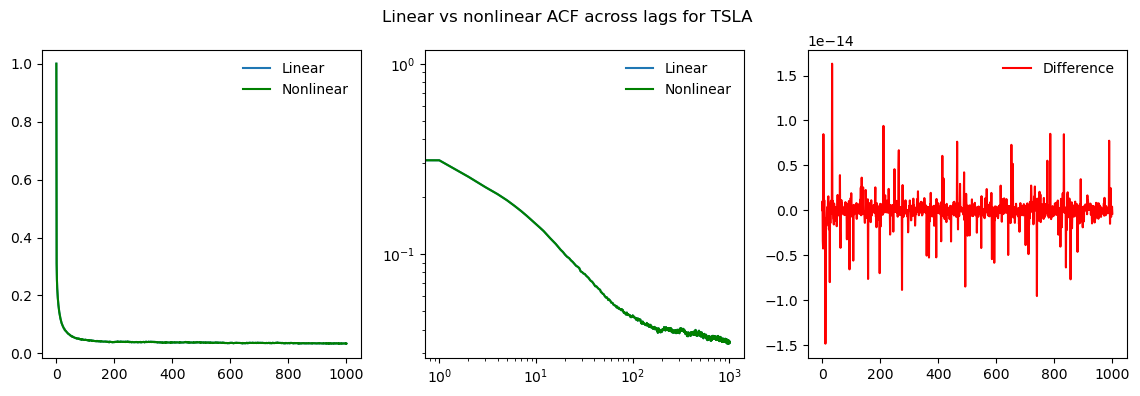

TSLA Max difference: 1.63202784619898e-14


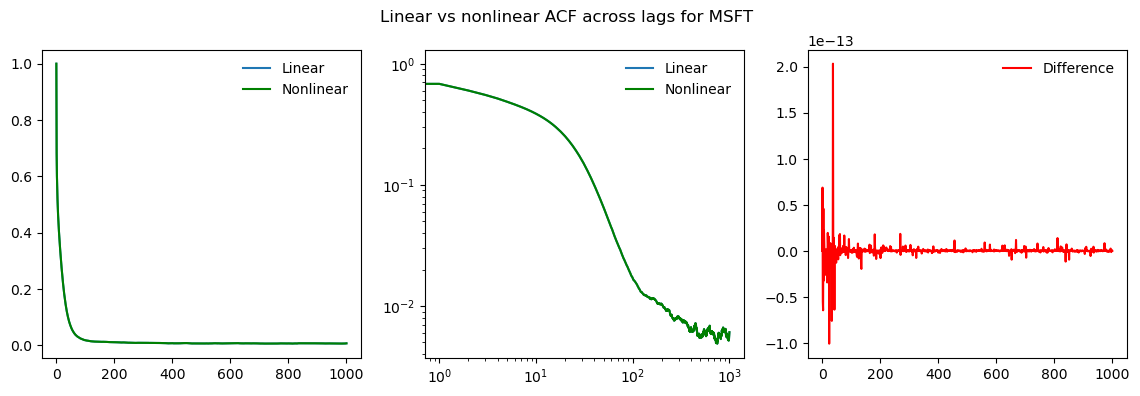

MSFT Max difference: 2.032124468698271e-13


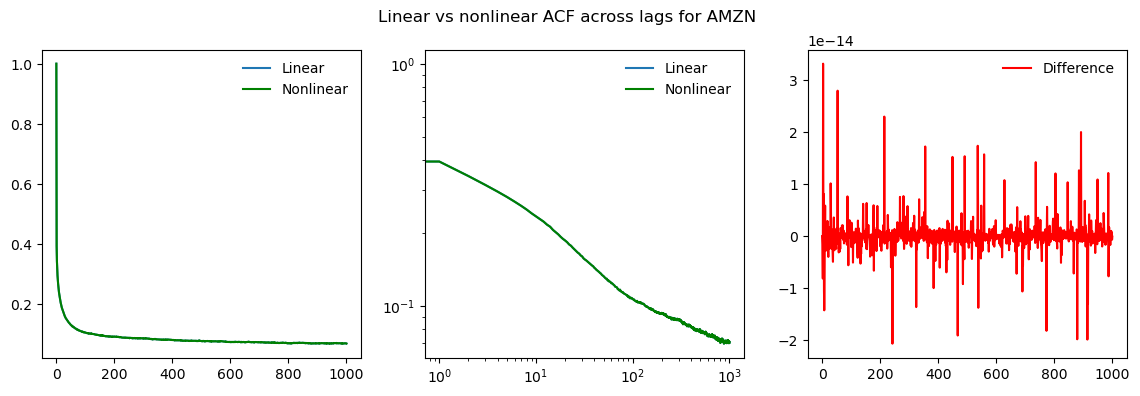

AMZN Max difference: 3.314015728506092e-14


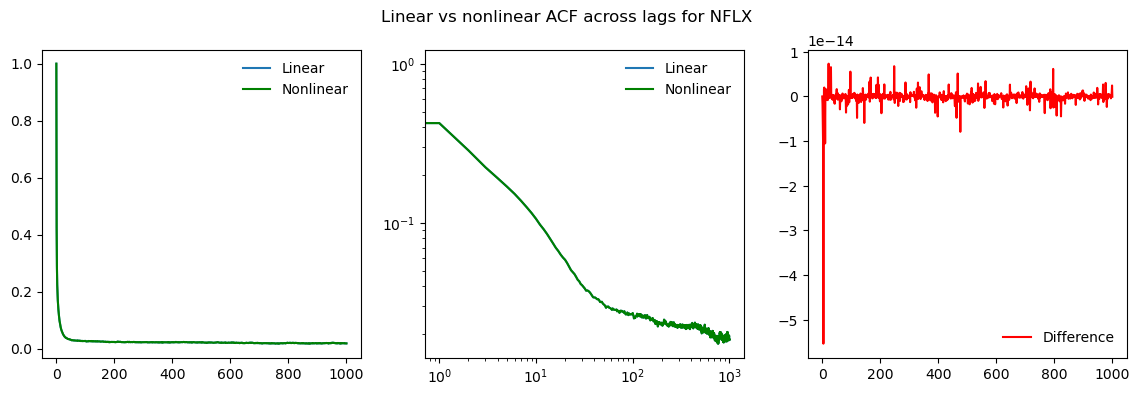

NFLX Max difference: 7.341349750333848e-15


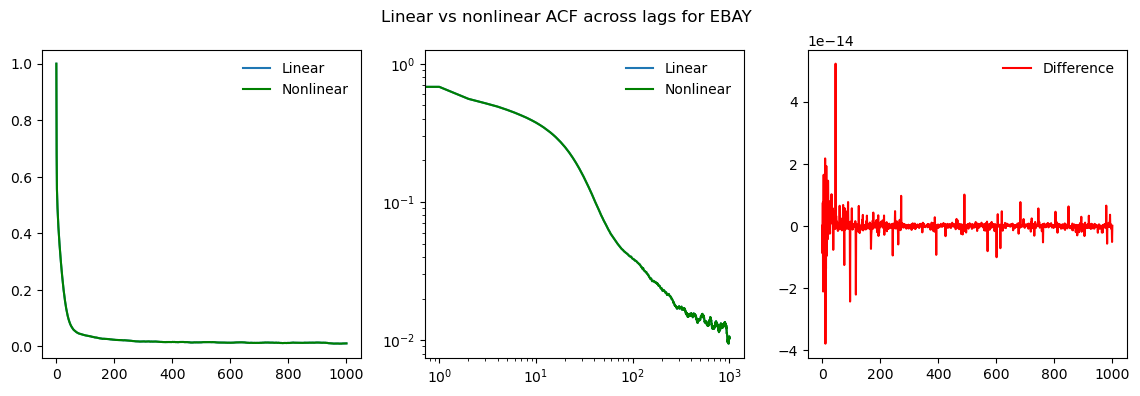

EBAY Max difference: 5.224987109642143e-14


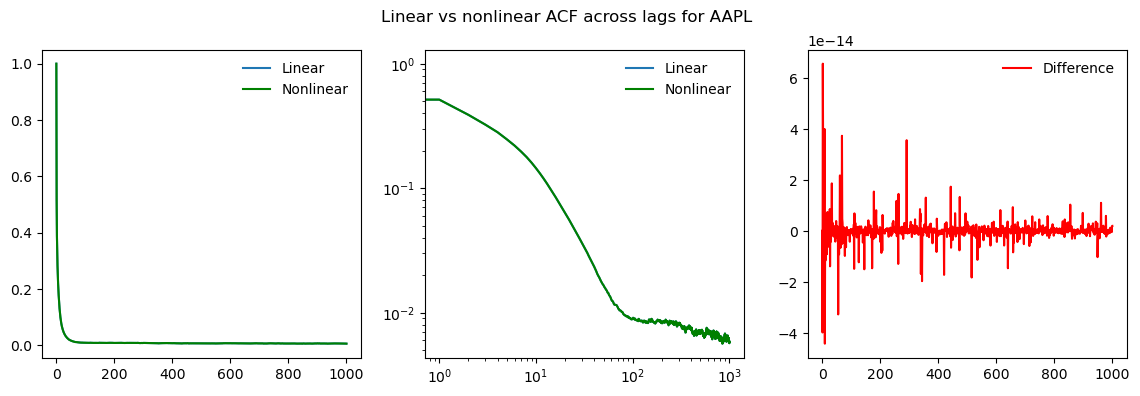

AAPL Max difference: 6.550315845288424e-14


In [10]:
for stock_name in signs_linear_acfs.keys():
    plot_acf_difference(stock_name, signs_linear_acfs, signs_nonlinear_acfs)

### 1.2. Fit power law to ACF

In [11]:
# Load the pre-computed ACFs
signs_acf_values = {}

for stock, data in signs_nonlinear_acfs.items():
    signs_acf_values[stock] = construct_xy(data, stock)

In [12]:
# Using signs_nonlinear_acfs
signs_fit_results_list = []
signs_fit_objects = {}  # Dictionary to store fit objects

for stock, data in signs_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[stock] = fit_obj  # Store the fit object

signs_acf_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0726705...",90,91.0,0.052689,-13008.234450,1.494685,0.911021,-0.107528,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0362662...",234,235.0,0.087353,-11646.520401,6.466544,0.660009,-0.276806,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2223428...",386,387.0,0.050407,-9048.676127,0.670162,0.966601,-0.167642,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0919253...",392,393.0,0.062397,-8827.075843,2.782982,0.760177,-0.232337,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1137913...",272,273.0,0.106996,-10473.767364,4.838150,0.833681,-0.332814,EBAY


In [13]:
signs_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [14]:
avg_alpha = signs_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.22115238405053453


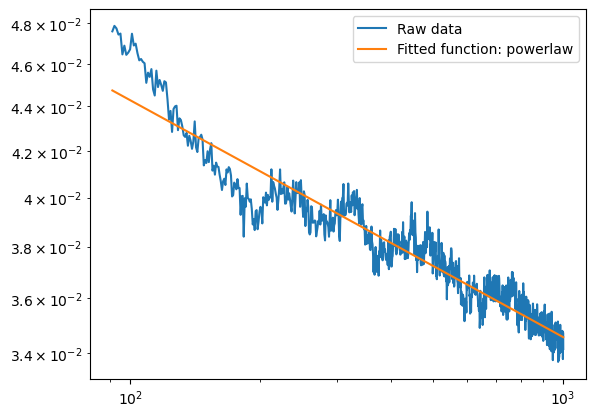

In [15]:
tsla_acf_fit = signs_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 1.3. Signed Orderflow Hurst Exponents

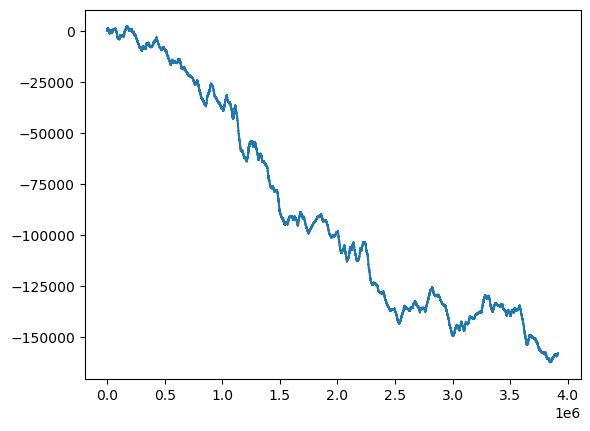

In [16]:
# Compute cumsum of signed orderflow
cumsum_signed_orderflow = {
  'TSLA': tsla_raw_df['sign'].cumsum(),
  'MSFT': msft_raw_df['sign'].cumsum(),
  'AMZN': amzn_raw_df['sign'].cumsum(),
  'NFLX': nflx_raw_df['sign'].cumsum(),
  'EBAY': ebay_raw_df['sign'].cumsum(),
  'AAPL': appl_raw_df['sign'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# cumsum_signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_signed_orderflow.items()}
tsla_cumsum_signs = tsla_raw_df['sign'].cumsum()
x = list(range(1, len(tsla_cumsum_signs)+1))
plt.plot(x, tsla_cumsum_signs)
plt.grid(False)

#### Standard Hurst

In [17]:
# Standard Hurst
method = 'standard'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_std_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9453646...",1,1.0,0.010116,-12518.804931,0.396488,0.999978,0.773178,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.1436142...",3133,58.0,0.023840,-13267.976144,0.122475,0.999818,0.670581,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9042134...",1,1.0,0.010590,-13141.852226,0.342263,0.999991,0.840799,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2015411...",405,19.0,0.012679,-13151.944584,0.127666,0.999977,0.688535,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.9152777...",1921,54.0,0.022209,-9759.928833,0.121265,0.999874,0.694953,EBAY,signs
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.7171070...",2088,37.0,0.015890,-21415.434626,0.204124,0.999828,0.624038,AAPL,signs


In [18]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = signs_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.7153475413067069


#### Generalized Hurst

In [19]:
# Generalized Hurst
method = 'generalized'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_gen_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.8303926...",281,15.0,0.011786,-14218.964056,0.090263,0.999993,0.754245,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.3528064...",3188,59.0,0.024423,-13406.551031,0.130318,0.999740,0.612128,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.8209878...",22,2.0,0.010703,-13194.874963,0.328431,0.999987,0.818247,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0614732...",360,17.0,0.012372,-14648.848910,0.117138,0.999981,0.666287,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.1021609...",2102,59.0,0.024916,-9691.047579,0.097783,0.999865,0.637602,EBAY,signs


In [20]:
# Generalized Hurst statistic across stocks
min_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = signs_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5994564034253362
Max Generalized Hurst: 0.8182469880217065
Average Generalized Hurst: 0.6813273630546685
Standard_dev Generalized Hurst: 0.08682568513980712


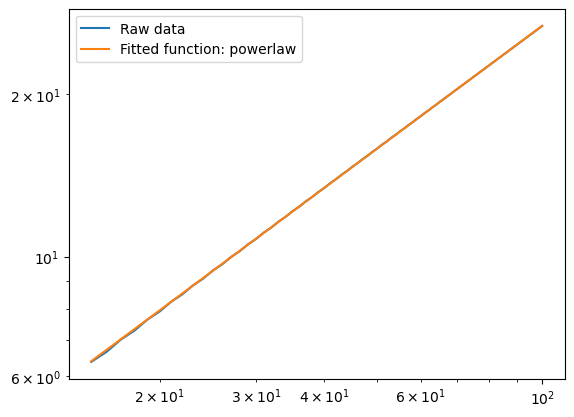

In [21]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = signs_fit_objects[('TSLA', 'generalized', 'signs')]
tsla_generalized_fit.powerlaw.plot_fit()

## 2. Size/ Volume

In [22]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['norm_size'],
               'MSFT': amzn_raw_df['norm_size'],
               'AMZN': nflx_raw_df['norm_size'],
               'NFLX': msft_raw_df['norm_size'],
               'EBAY': ebay_raw_df['norm_size'],
               'AAPL': appl_raw_df['norm_size'],
               }

# Order signed volume
signed_volume = {'TSLA': tsla_raw_df['signed_volume'],
               'MSFT': amzn_raw_df['signed_volume'],
               'AMZN': nflx_raw_df['signed_volume'],
               'NFLX': msft_raw_df['signed_volume'],
               'EBAY': ebay_raw_df['signed_volume'],
               'AAPL': appl_raw_df['signed_volume'],
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
#size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [23]:
# ADF test
for stock, data in signed_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -32.28
p-value: 0.00,
N: 99934, 
critical values: {'1%': -3.4304154378687812, '5%': -2.8615689225125784, '10%': -2.5667853944414167}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -41.80
p-value: 0.00,
N: 99968, 
critical values: {'1%': -3.4304154156122126, '5%': -2.861568912675632, '10%': -2.5667853892055357}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -38.65
p-value: 0.00,
N: 99955, 
critical values: {'1%': -3.430415424120289, '5%': -2.861568916436027, '10%': -2.5667853912070697}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -48.30
p-value: 0.00,
N: 99984, 
critical values: {'1%': -3.430415405143771, '5%': -2.861568908048796, '10%': -2.566785386742824}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
A

### 2.1. Size/volume ACF

In [24]:
# Linear ACF
volume_linear_acf_filename = f"{acf_data_dir}/lo_volume_linear_acfs.pkl"
volume_linear_acfs = compute_acfs(filename=volume_linear_acf_filename, data=signed_volume, option='linear')
print(volume_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [25]:
# Nonlinear ACF
volume_nonlinear_acf_filename = f"{acf_data_dir}/lo_volume_nonlinear_acfs.pkl"
volume_nonlinear_acfs = compute_acfs(filename=volume_nonlinear_acf_filename, data=signed_volume, option='nonlinear')
print(volume_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


[autoreload of liquidity.util.limit_orders_data_util failed: Traceback (most recent call last):
  File "/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/util/limit_orders_data_util.py", line 5, in <module>
    from liquidity import add_mean_queue_lengths
ImportErr

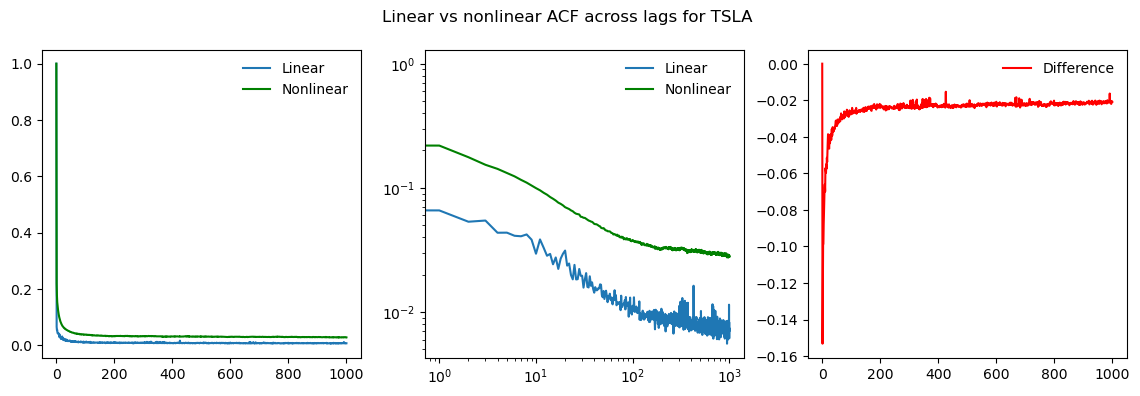

TSLA Max difference: 2.220446049250313e-16


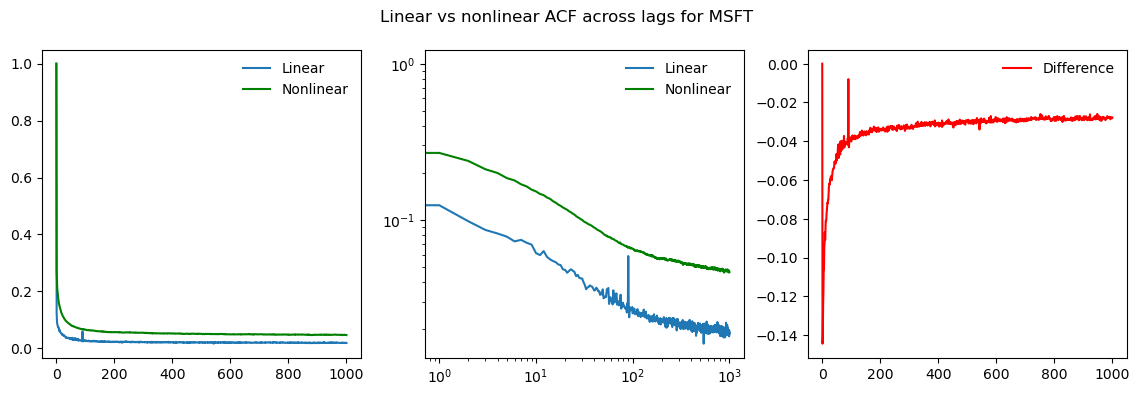

MSFT Max difference: 0.0


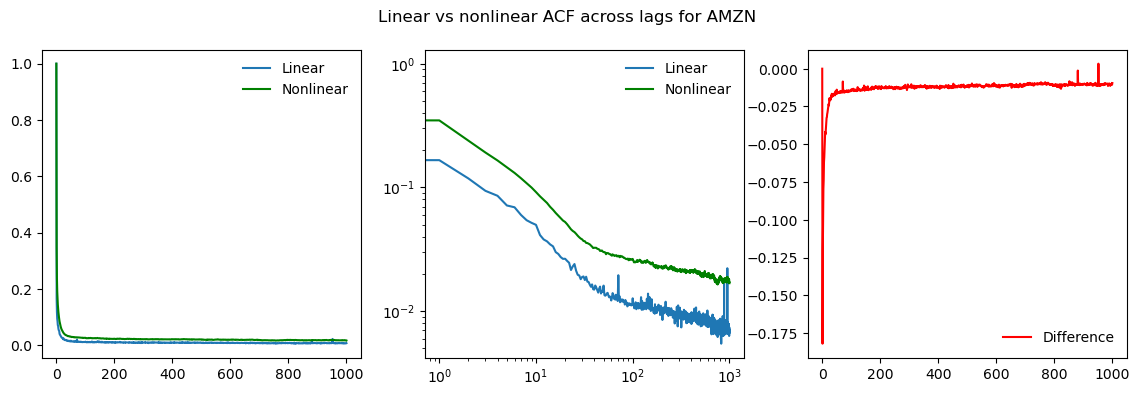

AMZN Max difference: 0.003321599830744676


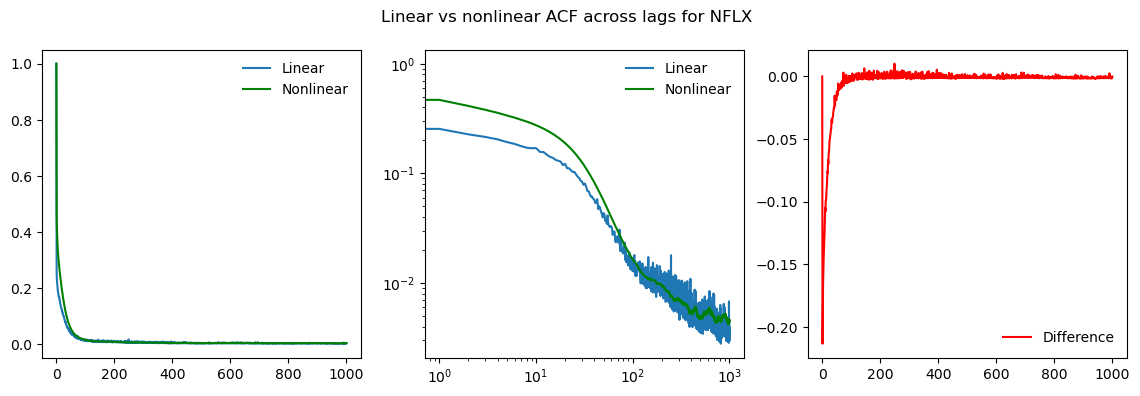

NFLX Max difference: 0.010179883972334236


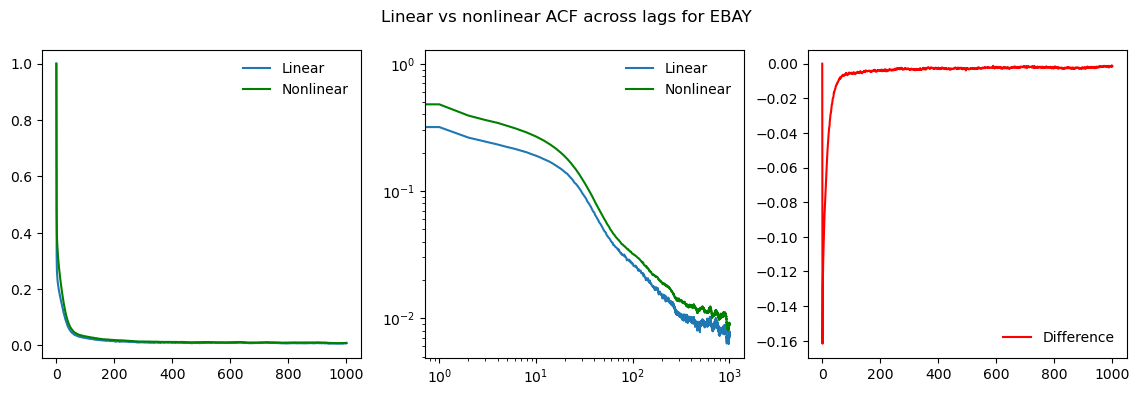

EBAY Max difference: -2.220446049250313e-16


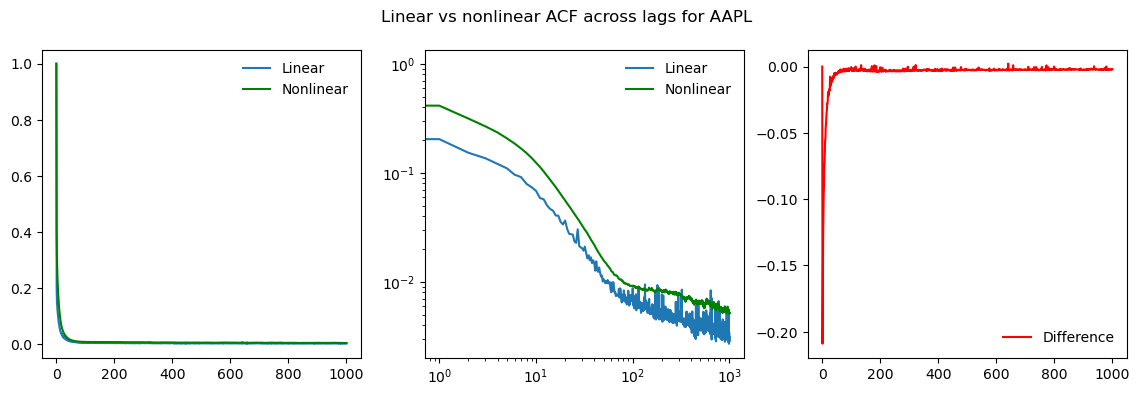

AAPL Max difference: 0.0021764302045117635


In [26]:
for stock_name in volume_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_linear_acfs, volume_nonlinear_acfs)

### 2.2. Fit power law to ACF

In [27]:
# Load the pre-computed ACFs
volume_acf_values = {}

for stock, data in volume_nonlinear_acfs.items():
    volume_acf_values[stock] = construct_xy(data, stock)

In [28]:
# Nonlinear ACF
volume_nonlinear_acf_filename = f"{acf_data_dir}/lo_volume_nonlinear_acfs.pkl"
volume_nonlinear_acfs = compute_acfs(filename=volume_nonlinear_acf_filename, data=signed_volume, option='nonlinear')
print(volume_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [29]:
# Using volume_nonlinear_acfs
volume_fit_results_list = []
volume_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[stock] = fit_obj  # Store the fit object

volume_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0578385...",84,85.0,0.058888,-13571.319156,1.427989,0.916932,-0.102737,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0996839...",297,298.0,0.032670,-10940.590087,0.661342,0.950963,-0.109027,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0657392...",24,25.0,0.064483,-13655.901935,2.840996,0.937201,-0.193579,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0378563...",283,284.0,0.062674,-11380.242713,5.603071,0.718755,-0.310188,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0725022...",292,293.0,0.121298,-10591.869173,4.129623,0.805713,-0.291617,EBAY


In [30]:
volume_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [31]:
avg_alpha = volume_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.21189380332226268


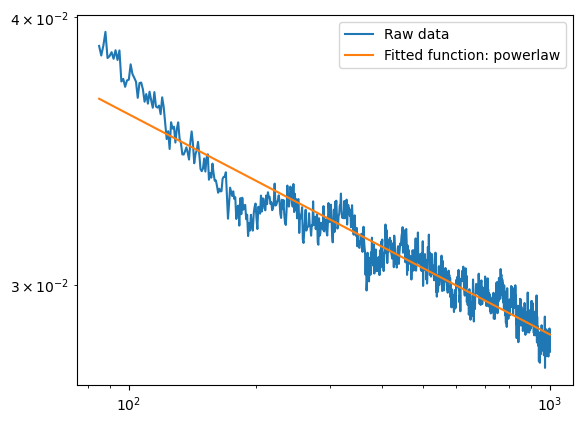

In [32]:
tsla_acf_fit = volume_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3. Size/ Volume Hurst Exponents

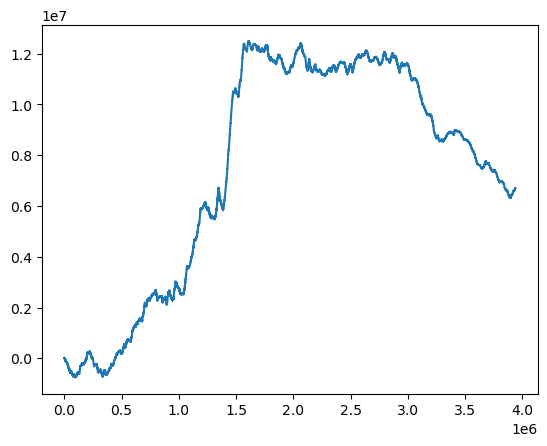

In [33]:
# Compute cumsum of size/volumes
cumsum_size_volume = {
               'TSLA': tsla_raw_df['norm_size'].cumsum(),
               'MSFT': amzn_raw_df['norm_size'].cumsum(),
               'AMZN': nflx_raw_df['norm_size'].cumsum(),
               'NFLX': msft_raw_df['norm_size'].cumsum(),
               'EBAY': ebay_raw_df['norm_size'].cumsum(),
               'AAPL': appl_raw_df['norm_size'].cumsum()
               }

cumsum_signed_volume = {
               'TSLA': tsla_raw_df['signed_volume'].cumsum(),
               'MSFT': amzn_raw_df['signed_volume'].cumsum(),
               'AMZN': nflx_raw_df['signed_volume'].cumsum(),
               'NFLX': msft_raw_df['signed_volume'].cumsum(),
               'EBAY': ebay_raw_df['signed_volume'].cumsum(),
               'AAPL': appl_raw_df['signed_volume'].cumsum()
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
#cumsum_size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_size_volume.items()}
tsla_cumsum_volume = amzn_raw_df['signed_volume'].cumsum()
x = list(range(1, len(tsla_cumsum_volume)+1))
plt.plot(x, tsla_cumsum_volume)
plt.grid(False)
plt.show()

#### Standard Hurst

In [34]:
# Standard Hurst
method = 'standard'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_signed_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_std_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_std_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:94: UserWarning: Hurst exponent not in a valid range (0, 1).
  warnings.warn("Hurst exponent not in a valid range (0, 1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:94: UserWarning: Hurst exponent not in a valid range (0, 1).
  warnings.warn("Hurst exponent not in a valid range (0, 1).")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 156.36818...",1975,99.0,0.666667,7.387750,4.980463e-02,1.040584e+00,0.685746,TSLA,volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0693859...",1961,98.0,1.000000,2363.332845,5.600216e+20,-3.280323e+42,25.653997,MSFT,volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 46.014225...",2197,99.0,0.954545,-46.488551,1.806986e-03,9.980130e-01,0.932388,AMZN,volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 135.45146...",5388,99.0,0.980769,-70.822430,1.828681e-03,9.982610e-01,0.916510,NFLX,volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.4326545...",3547,98.0,1.000000,6526.727592,2.450975e+33,-1.590299e+68,28.556493,EBAY,volume


In [35]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 9.581024959283885


In [36]:
display(volume_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'volume'), ('MSFT', 'standard', 'volume'), ('AMZN', 'standard', 'volume'), ('NFLX', 'standard', 'volume'), ('EBAY', 'standard', 'volume'), ('AAPL', 'standard', 'volume')])

#### Generalized Hurst

In [37]:
# Generalized Hurst
method = 'generalized'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_signed_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_gen_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 80.894258...",641,33.0,0.014959,-3513.675347,0.012750,1.000000,0.755757,TSLA,volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 55.865148...",1163,59.0,0.025579,-4924.368406,0.002407,1.000000,0.797627,MSFT,volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 104.87506...",1727,78.0,0.046748,-2241.714802,0.003637,0.999999,0.691297,AMZN,volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1284.1354...",5437,99.0,0.666667,15.795852,0.108054,1.309099,0.370582,NFLX,volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 380.91610...",3370,94.0,0.170507,-1051.292181,0.000885,0.999999,0.648978,EBAY,volume


In [38]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.3705818032949977
Max Generalized Hurst: 0.7976270085756133
Average Generalized Hurst: 0.6464599351855015
Standard_dev Generalized Hurst: 0.15095889872342982


In [39]:
print(volume_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volume'), ('MSFT', 'generalized', 'volume'), ('AMZN', 'generalized', 'volume'), ('NFLX', 'generalized', 'volume'), ('EBAY', 'generalized', 'volume'), ('AAPL', 'generalized', 'volume')])


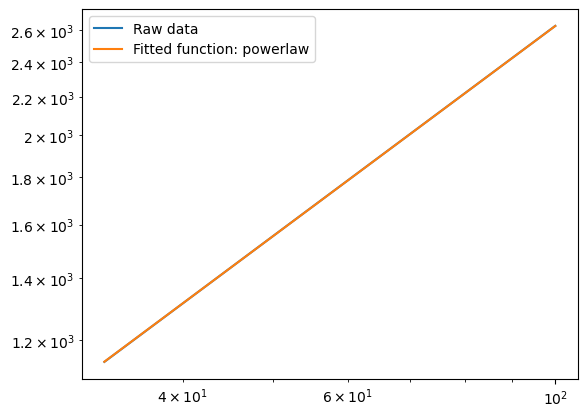

In [40]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volume_fit_objects[('TSLA', 'generalized', 'volume')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Signed Ordeflow Imbalance

In [41]:
# Aggregate orderflow
tsla_aggregate_orderflow = compute_aggregate_features(tsla_raw_df, [LAG])
msft_aggregate_orderflow = compute_aggregate_features(msft_raw_df, [LAG])
amzn_aggregate_orderflow = compute_aggregate_features(amzn_raw_df, [LAG])
nflx_aggregate_orderflow = compute_aggregate_features(nflx_raw_df, [LAG])
ebay_aggregate_orderflow = compute_aggregate_features(ebay_raw_df, [LAG])
appl_aggregate_orderflow = compute_aggregate_features(appl_raw_df, [LAG])

# Normalize imblances
tsla_aggregate_orderflow = normalize_imbalances(tsla_aggregate_orderflow)
msft_aggregate_orderflow = normalize_imbalances(msft_aggregate_orderflow)
amzn_aggregate_orderflow = normalize_imbalances(amzn_aggregate_orderflow)
nflx_aggregate_orderflow = normalize_imbalances(nflx_aggregate_orderflow)
ebay_aggregate_orderflow = normalize_imbalances(ebay_aggregate_orderflow)
appl_aggregate_orderflow = normalize_imbalances(appl_aggregate_orderflow)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'AAPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}


# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['volume_imbalance'],
 'MSFT': msft_aggregate_orderflow['volume_imbalance'],
 'AMZN': amzn_aggregate_orderflow['volume_imbalance'],
 'NFLX': nflx_aggregate_orderflow['volume_imbalance'],
 'EBAY': ebay_aggregate_orderflow['volume_imbalance'],
 'AAPL': appl_aggregate_orderflow['volume_imbalance']
}
#volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

KeyError: "Column(s) ['average_vol_at_best'] do not exist"

#### Stationarity Test

In [ ]:
# Sign imbalance ADF test
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

In [ ]:
# Volume imbalance ADF test
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 3.1. Order sign imbalance long memory

In [ ]:
# Linear ACF
sign_imbalance_linear_acf_filename = f"{acf_data_dir}/lo_sign_imbalance_linear_acfs.pkl"
sign_imbalance_linear_acfs = compute_acfs(filename=sign_imbalance_linear_acf_filename, data=sign_imbalance, option='linear')
print(sign_imbalance_linear_acfs.keys())

In [ ]:
# Nonlinear ACF
sign_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/lo_sign_imbalance_nonlinear_acfs.pkl"
sign_imbalance_nonlinear_acfs = compute_acfs(filename=sign_imbalance_nonlinear_acf_filename, data=sign_imbalance, option='nonlinear')
print(sign_imbalance_nonlinear_acfs.keys())

In [ ]:
for stock_name in sign_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, sign_imbalance_linear_acfs, sign_imbalance_nonlinear_acfs)

#### 3.1.1. Fit power law to ACF

In [ ]:
# Load the pre-computed ACFs
sign_imbalance_acf_values = {}

for stock, data in sign_imbalance_nonlinear_acfs.items():
    sign_imbalance_acf_values[stock] = construct_xy(data, stock)

In [ ]:
# Using signs_imbalance_nonlinear_acfs
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in sign_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

sign_imbalance_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_fit_results.head())

In [ ]:
print(sign_imbalance_fit_objects.keys())

In [ ]:
avg_alpha = sign_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

In [ ]:
tsla_acf_fit = sign_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 3.1.2. Sign Imbalance Hurst Exponents

In [ ]:
# Compute cumsum of order sign imbalance
cumsum_sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'].cumsum(),
  'MSFT': msft_aggregate_orderflow['sign_imbalance'].cumsum(),
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'].cumsum(),
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'].cumsum(),
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'].cumsum(),
  'AAPL': appl_aggregate_orderflow['sign_imbalance'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# cumsum_sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_sign_imbalance.items()}
tsla_cumsum_sign_imbalance = tsla_aggregate_orderflow['sign_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_sign_imbalance)+1))
plt.plot(x, tsla_cumsum_sign_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [ ]:
# Standard Hurst
method = 'standard'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('sign_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signs_imbalance')] = fit

sign_imbalance_std_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_std_hurst_fit_results.head())

In [ ]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = sign_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

##### Generalized Hurst

In [ ]:
# Generalized Hurst
method = 'generalized'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('signed_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signed_imbalance')] = fit

sign_imbalance_gen_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_gen_hurst_fit_results.head())

In [ ]:
# Generalized Hurst statistic across stocks
min_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

In [ ]:
print(sign_imbalance_fit_objects.keys())

In [ ]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = sign_imbalance_fit_objects[('TSLA', 'generalized', 'signed_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()

### 3.2. Signed Volume imbalance long memory

In [ ]:
# Linear ACF
volume_imbalance_linear_acf_filename = f"{acf_data_dir}/lo_volume_imbalance_linear_acfs.pkl"
volume_imbalance_linear_acfs = compute_acfs(filename=volume_imbalance_linear_acf_filename, data=volume_imbalance, option='linear')
print(volume_imbalance_linear_acfs.keys())

In [ ]:
# Nonlinear ACF
volume_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/lo_volume_imbalance_nonlinear_acfs.pkl"
volume_imbalance_nonlinear_acfs = compute_acfs(filename=volume_imbalance_nonlinear_acf_filename, data=volume_imbalance, option='nonlinear')
print(volume_imbalance_nonlinear_acfs.keys())

In [ ]:
for stock_name in volume_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_imbalance_linear_acfs, volume_imbalance_nonlinear_acfs)

#### 3.2.1. Fit power law to ACF

In [ ]:
# Load the pre-computed ACFs
volume_imbalance_acf_values = {}

for stock, data in volume_imbalance_nonlinear_acfs.items():
    volume_imbalance_acf_values[stock] = construct_xy(data, stock)

In [ ]:
# Using signs_imbalance_nonlinear_acfs
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

volume_imbalance_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_fit_results.head())

In [ ]:
print(volume_imbalance_fit_objects.keys())

In [ ]:
avg_alpha = volume_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

In [ ]:
tsla_acf_fit = volume_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 3.2.2. Volume Imbalance Hurst Exponents

In [ ]:
# Compute cumsum of order sign imbalance
cumsum_volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['volume_imbalance'].cumsum(),
 'MSFT': msft_aggregate_orderflow['volume_imbalance'].cumsum(),
 'AMZN': amzn_aggregate_orderflow['volume_imbalance'].cumsum(),
 'NFLX': nflx_aggregate_orderflow['volume_imbalance'].cumsum(),
 'EBAY': ebay_aggregate_orderflow['volume_imbalance'].cumsum(),
 'AAPL': appl_aggregate_orderflow['volume_imbalance'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#cumsum_volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_volume_imbalance.items()}
tsla_cumsum_volume_imbalance = tsla_aggregate_orderflow['volume_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_volume_imbalance)+1))
plt.plot(x, tsla_cumsum_volume_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [ ]:
# Standard Hurst
method = 'standard'
volume_imbalance_fit_results_list = []
voliume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        voliume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_std_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_std_hurst_fit_results.head())

In [ ]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

##### Generalized Hurst

In [ ]:
# Generalized Hurst
method = 'generalized'
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_gen_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_gen_hurst_fit_results.head())

In [ ]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

In [ ]:
display(volume_imbalance_fit_objects.keys())

In [ ]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = volume_imbalance_fit_objects[('TSLA', 'generalized', 'volume_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()